In [1]:
!pip list

Package                 Version
----------------------- -----------
absl-py                 1.4.0
aiohttp                 3.9.3
aiosignal               1.2.0
array-record            0.4.1
asttokens               2.4.1
astunparse              1.6.3
async-timeout           4.0.3
attrs                   23.1.0
blinker                 1.6.2
Brotli                  1.0.9
cachetools              4.2.2
certifi                 2024.2.2
cffi                    1.16.0
charset-normalizer      2.0.4
click                   8.1.7
colorama                0.4.6
comm                    0.2.2
contourpy               1.1.1
cryptography            41.0.3
cycler                  0.11.0
debugpy                 1.8.1
decorator               5.1.1
dill                    0.3.7
dm-tree                 0.1.8
etils                   1.5.0
exceptiongroup          1.2.0
executing               2.0.1
flatbuffers             2.0
fonttools               4.42.1
frozenlist              1.4.0
fsspec                  20

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


In [3]:
original_data_path = "../Data/original"
preped_data_path = "../Data/preped_data"
folderList = os.listdir(original_data_path)
print(folderList)

['blackheads', 'cyst', 'nodules', 'papules', 'pustules', 'whiteheads']


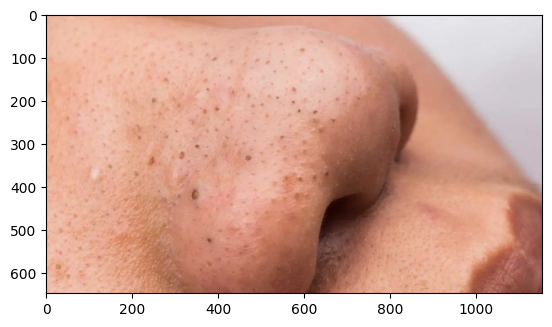

In [4]:
#displaying a sample image
img = np.asarray(Image.open(original_data_path+'/blackheads/1.jpg'))
imgplot = plt.imshow(img)

In [5]:
img.shape #(H,W,D)

(648, 1155, 3)

Let's try to find out the minumum resolution within the dataset images

In [6]:
min_w = 10000
min_h = 10000
for folder in folderList:
    images = os.listdir(original_data_path+'/'+folder)
    for image in images:
        img = Image.open(original_data_path+'/'+folder+'/'+image)
        w,h = img.size
        if w<min_w:
            min_w = w
        if h<min_h:
            min_h = h
            
print(f'Min Weight : {min_w}\nMin Height : {min_h}')

Min Weight : 126
Min Height : 79


There fore we have to resize the images in to (125,75) #(W,H) to create the dataset

In [37]:
#resizing the images
target_resolution = (125, 75)  # Example target resolution
resized_images = []
labels = []

for folder in folderList:
    images = os.listdir(original_data_path+'/'+folder)
    for image in images:
        img_path = original_data_path+'/'+folder+'/'+image
        image_name = os.path.splitext(os.path.basename(img_path))[0] # image name without extension
        with Image.open(img_path) as img:
            resized_img = img.resize(target_resolution)
            resized_images.append(np.asarray(resized_img.convert('RGB')))
            #saving the resized images
            directory = preped_data_path+'/'+folder
            os.makedirs(directory, exist_ok=True)
            resized_img.convert('RGB').save(directory+'/'+image)
        labels.append(folder)

In [41]:
targets = np.asarray(resized_images)
labels = np.asarray(labels)

In [42]:
targets.shape

(2017, 75, 125, 3)

In [44]:
labels.shape

(2017,)

In [45]:
#checking the number of the samples we have
for folder in folderList:
    print(f"{folder} count : {len(os.listdir(preped_data_path+'/'+folder))}")

blackheads count : 290
cyst count : 338
nodules count : 217
papules count : 540
pustules count : 530
whiteheads count : 102


Since the datasets are small, data augmentation can be used to increase the number

In [69]:
num_of_classes = 6

#redifining the data
X = targets
y = labels

# Convert class names to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Find the class with the maximum number of samples
max_samples = np.max([np.sum(y_encoded == i) for i in range(num_of_classes)])

# Upsample the minority classes
X_upsampled = []
y_upsampled = []
for i in range(num_of_classes):
    X_class = X[y_encoded == i]
    X_upsampled.append(resample(X_class,
                                 replace=True,  # sample with replacement
                                 n_samples=max_samples,  # match number in majority class
                                 random_state=42))  # reproducible results
    y_upsampled.extend([i] * max_samples)

X_upsampled = np.concatenate(X_upsampled, axis=0)
y_upsampled = np.array(y_upsampled)

# Now X_upsampled and y_upsampled contain the balanced dataset

In [70]:
X_upsampled.shape

(3240, 75, 125, 3)

In [71]:
y_upsampled.shape

(3240,)

In [72]:
#Checking on the number of unique labels generated at each class
unique_labels, label_counts = np.unique(y_upsampled, return_counts=True)
total_samples = len(y_upsampled)

label_percentages = {}
for label, count in zip(unique_labels, label_counts):
    percentage = (count / total_samples) * 100
    label_percentages[label] = percentage

print("Label percentages:")
for label, percentage in label_percentages.items():
    print(f"Label {label}: {percentage:.2f}%")

Label percentages:
Label 0: 16.67%
Label 1: 16.67%
Label 2: 16.67%
Label 3: 16.67%
Label 4: 16.67%
Label 5: 16.67%


In [74]:
final_targets = np.array(X_upsampled)
final_labels = np.array(y_upsampled)

In [76]:
print(f"targets shape : {final_targets.shape}")
print(f"labels shape : {final_labels.shape}")

targets shape : (3240, 75, 125, 3)
labels shape : (3240,)


In [80]:
np.save('Input/targets.npy',final_targets)
np.save('Input/labels.npy',final_labels)